步骤 1: 加载数据
总样本数: 5172
垃圾邮件: 1500 (29.0%)
正常邮件: 3672 (71.0%)

步骤 2: 特征提取 (TF-IDF)
训练集形状: (4137, 5000)
测试集形状: (1035, 5000)

步骤 3: 构建变分贝叶斯模型

步骤 4: 使用 SVI (随机变分推断) 训练模型
开始变分推断训练...
迭代       ELBO损失          状态
----------------------------------------
500      1128.68         训练中...
1000     1071.16         训练中...
1500     1058.36         训练中...
2000     1054.52         训练中...
2500     1057.84         训练中...
3000     1054.98         训练中...

训练完成! 最终ELBO损失: 1047.85

训练损失曲线已保存为 training_loss.png

步骤 5: 预测测试集

使用 1000 个后验样本进行预测...

步骤 6: 模型评估
准确率: 0.9845

分类报告:
              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99       735
        Spam       0.98      0.97      0.97       300

    accuracy                           0.98      1035
   macro avg       0.98      0.98      0.98      1035
weighted avg       0.98      0.98      0.98      1035


前 15 个预测样本 (包括后验不确定性):
真实     预测概率         标准差        预测    
----------------------------------------
Ham    0.0

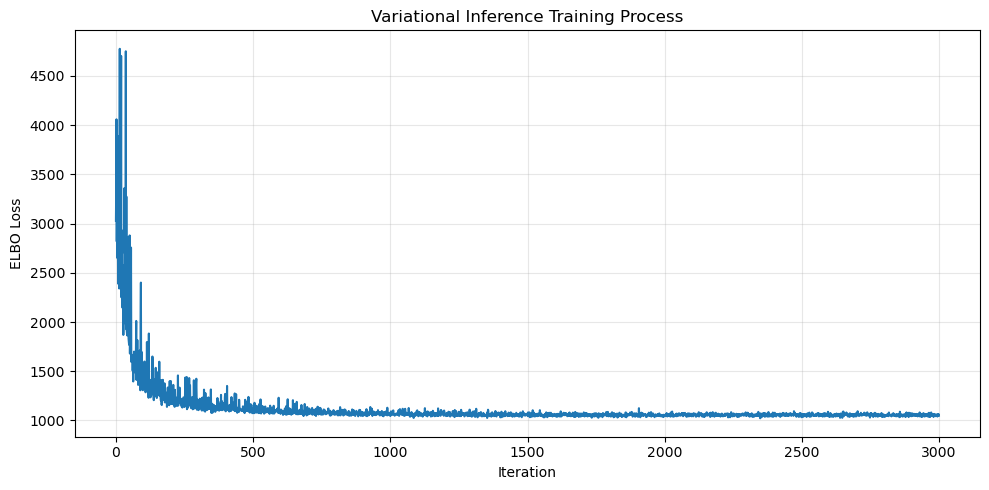

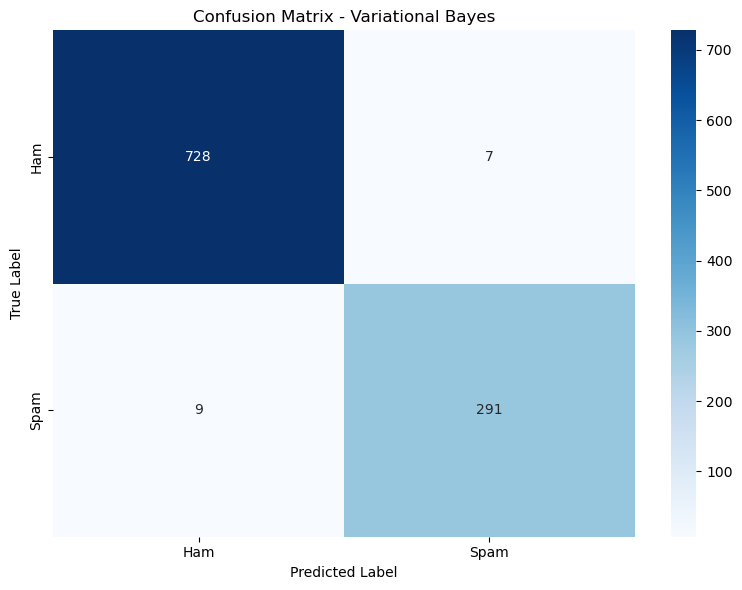

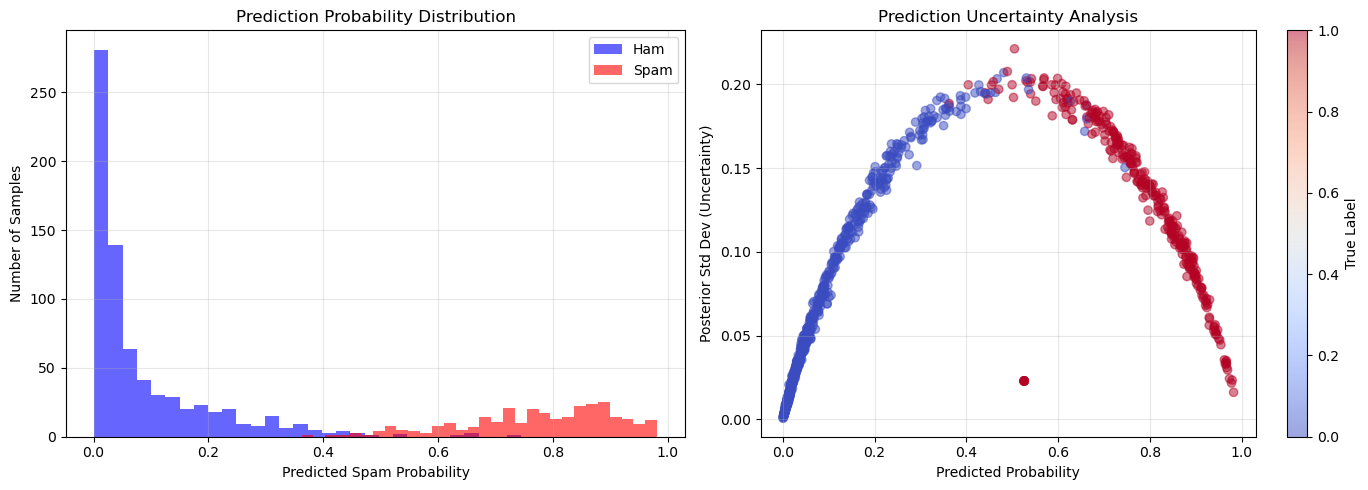

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# 设置随机种子
pyro.set_rng_seed(42)
torch.manual_seed(42)
np.random.seed(42)


# 数据加载
def load_data(directory):
    labels = []
    texts = []

    for label in ['ham', 'spam']:
        path = os.path.join(directory, label)
        if not os.path.exists(path):
            print(f"警告: 路径 {path} 不存在")
            continue
        for filename in os.listdir(path):
            try:
                with open(os.path.join(path, filename), 'r', encoding='latin1') as file:
                    texts.append(file.read())
                    labels.append(1 if label == 'spam' else 0)
            except Exception as e:
                print(f"跳过文件 {filename}: {e}")

    return texts, labels


class BayesianLogisticRegression:
    def __init__(self, input_dim):
        self.input_dim = input_dim

    def model(self, X, y=None):
        """
        贝叶斯逻辑回归的生成模型
        """
        # 权重的先验分布: Normal(0, 1)
        w_prior = dist.Normal(
            torch.zeros(self.input_dim),
            torch.ones(self.input_dim)
        ).to_event(1)

        # 截距的先验分布: Normal(0, 10)
        b_prior = dist.Normal(torch.tensor(0.), torch.tensor(10.))

        # 从先验分布采样
        w = pyro.sample("weights", w_prior)
        b = pyro.sample("intercept", b_prior)

        # 计算逻辑回归
        logits = torch.matmul(X, w) + b

        # 似然函数: Bernoulli分布
        with pyro.plate("data", X.shape[0]):
            obs = pyro.sample("obs", dist.Bernoulli(logits=logits), obs=y)

        return obs

    def guide(self, X, y=None):
        """
        变分后验分布 (使用自动变分推断)
        这里使用对角正态分布作为近似后验
        """
        # 权重的变分参数
        w_loc = pyro.param("w_loc", torch.zeros(self.input_dim))
        w_scale = pyro.param("w_scale", torch.ones(self.input_dim),
                             constraint=dist.constraints.positive)

        # 截距的变分参数
        b_loc = pyro.param("b_loc", torch.tensor(0.))
        b_scale = pyro.param("b_scale", torch.tensor(1.),
                             constraint=dist.constraints.positive)

        # 定义变分后验
        w_dist = dist.Normal(w_loc, w_scale).to_event(1)
        b_dist = dist.Normal(b_loc, b_scale)

        # 从变分后验采样
        w = pyro.sample("weights", w_dist)
        b = pyro.sample("intercept", b_dist)

        return {"weights": w, "intercept": b}


def train_variational_bayes(model, guide, X_train, y_train, num_iterations=3000, lr=0.01):
    """
    使用随机变分推断 (SVI) 训练模型
    """
    # 清除参数存储
    pyro.clear_param_store()

    # 设置优化器和损失函数
    optimizer = Adam({"lr": lr})
    svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

    # 训练循环
    losses = []
    print("开始变分推断训练...")
    print(f"{'迭代':<8} {'ELBO损失':<15} {'状态'}")
    print("-" * 40)

    for iteration in range(num_iterations):
        loss = svi.step(X_train, y_train)
        losses.append(loss)

        if (iteration + 1) % 500 == 0:
            avg_loss = np.mean(losses[-100:])
            print(f"{iteration + 1:<8} {avg_loss:<15.2f} {'训练中...'}")

    print(f"\n训练完成! 最终ELBO损失: {losses[-1]:.2f}")

    return losses


def predict(model, guide, X_test, num_samples=1000):
    """
    使用训练好的变分后验进行预测
    """
    print(f"\n使用 {num_samples} 个后验样本进行预测...")

    # 从变分后验采样
    predictions = []

    for _ in range(num_samples):
        # 从guide采样参数
        guide_trace = pyro.poutine.trace(guide).get_trace(X_test)
        w = guide_trace.nodes["weights"]["value"]
        b = guide_trace.nodes["intercept"]["value"]

        # 计算预测
        logits = torch.matmul(X_test, w) + b
        probs = torch.sigmoid(logits)
        predictions.append(probs.detach().numpy())

    # 计算预测的后验均值
    predictions = np.array(predictions)
    mean_probs = predictions.mean(axis=0)
    std_probs = predictions.std(axis=0)

    return mean_probs, std_probs


def main():
    data_dir = '/Users/Shared/datasets/enron1'

    # 加载数据
    print("=" * 60)
    print("步骤 1: 加载数据")
    print("=" * 60)
    texts, labels = load_data(data_dir)
    print(f"总样本数: {len(texts)}")
    print(f"垃圾邮件: {sum(labels)} ({sum(labels) / len(labels) * 100:.1f}%)")
    print(f"正常邮件: {len(labels) - sum(labels)} ({(len(labels) - sum(labels)) / len(labels) * 100:.1f}%)")

    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(
        texts, labels, test_size=0.2, random_state=42, stratify=labels
    )

    # 特征提取
    print("\n" + "=" * 60)
    print("步骤 2: 特征提取 (TF-IDF)")
    print("=" * 60)
    vectorizer = TfidfVectorizer(
        stop_words='english',
        max_features=5000,
        min_df=2,
        max_df=0.8
    )
    X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
    X_test_tfidf = vectorizer.transform(X_test).toarray()

    print(f"训练集形状: {X_train_tfidf.shape}")
    print(f"测试集形状: {X_test_tfidf.shape}")

    # 转换为PyTorch张量
    X_train_tensor = torch.FloatTensor(X_train_tfidf)
    y_train_tensor = torch.FloatTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test_tfidf)

    # 创建模型
    print("\n" + "=" * 60)
    print("步骤 3: 构建变分贝叶斯模型")
    print("=" * 60)
    input_dim = X_train_tfidf.shape[1]
    bayesian_lr = BayesianLogisticRegression(input_dim)

    # 训练模型
    print("\n" + "=" * 60)
    print("步骤 4: 使用 SVI (随机变分推断) 训练模型")
    print("=" * 60)
    losses = train_variational_bayes(
        bayesian_lr.model,
        bayesian_lr.guide,
        X_train_tensor,
        y_train_tensor,
        num_iterations=3000,
        lr=0.01
    )

    # 绘制训练损失
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.xlabel('Iteration')
    plt.ylabel('ELBO Loss')
    plt.title('Variational Inference Training Process')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('training_loss.png', dpi=300, bbox_inches='tight')
    print("\n训练损失曲线已保存为 training_loss.png")

    # 预测
    print("\n" + "=" * 60)
    print("步骤 5: 预测测试集")
    print("=" * 60)
    mean_probs, std_probs = predict(
        bayesian_lr.model,
        bayesian_lr.guide,
        X_test_tensor,
        num_samples=1000
    )

    y_pred = (mean_probs > 0.5).astype(int)

    # 评估
    print("\n" + "=" * 60)
    print("步骤 6: 模型评估")
    print("=" * 60)
    print(f"准确率: {accuracy_score(y_test, y_pred):.4f}")
    print("\n分类报告:")
    print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

    # 显示预测示例（包括不确定性）
    print("\n前 15 个预测样本 (包括后验不确定性):")
    print(f"{'真实':<6} {'预测概率':<12} {'标准差':<10} {'预测':<6}")
    print("-" * 40)
    for i in range(min(15, len(y_test))):
        true_label = 'Spam' if y_test[i] else 'Ham'
        pred_label = 'Spam' if y_pred[i] else 'Ham'
        print(f"{true_label:<6} {mean_probs[i]:<12.4f} {std_probs[i]:<10.4f} {pred_label:<6}")

    # 绘制混淆矩阵
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Ham', 'Spam'],
                yticklabels=['Ham', 'Spam'])
    plt.title('Confusion Matrix - Variational Bayes')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix_vb.png', dpi=300, bbox_inches='tight')
    print("\n混淆矩阵已保存为 confusion_matrix_vb.png")

    # 绘制预测概率分布（包括不确定性）
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # 左图: 预测概率分布
    y_test_arr = np.array(y_test)
    axes[0].hist(mean_probs[y_test_arr == 0], bins=30, alpha=0.6, label='Ham', color='blue')
    axes[0].hist(mean_probs[y_test_arr == 1], bins=30, alpha=0.6, label='Spam', color='red')
    axes[0].set_xlabel('Predicted Spam Probability')
    axes[0].set_ylabel('Number of Samples')
    axes[0].set_title('Prediction Probability Distribution')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # 右图: 预测不确定性
    axes[1].scatter(mean_probs, std_probs, c=y_test_arr, cmap='coolwarm', alpha=0.5)
    axes[1].set_xlabel('Predicted Probability')
    axes[1].set_ylabel('Posterior Std Dev (Uncertainty)')
    axes[1].set_title('Prediction Uncertainty Analysis')
    axes[1].grid(True, alpha=0.3)
    axes[1].colorbar = plt.colorbar(axes[1].collections[0], ax=axes[1], label='True Label')

    plt.tight_layout()
    plt.savefig('prediction_analysis_vb.png', dpi=300, bbox_inches='tight')
    print("预测分析图已保存为 prediction_analysis_vb.png")

    # 显示后验参数
    print("\n" + "=" * 60)
    print("后验参数统计")
    print("=" * 60)
    w_loc = pyro.param("w_loc").detach().numpy()
    w_scale = pyro.param("w_scale").detach().numpy()
    b_loc = pyro.param("b_loc").detach().numpy()
    b_scale = pyro.param("b_scale").detach().numpy()

    print(f"截距后验均值: {b_loc:.4f} ± {b_scale:.4f}")
    print(f"权重后验均值范围: [{w_loc.min():.4f}, {w_loc.max():.4f}]")
    print(f"权重后验标准差范围: [{w_scale.min():.4f}, {w_scale.max():.4f}]")

    # 找出最重要的特征
    feature_names = vectorizer.get_feature_names_out()
    top_spam_indices = np.argsort(w_loc)[-10:][::-1]
    top_ham_indices = np.argsort(w_loc)[:10]

    print("\n最能表明垃圾邮件的词汇 (Top 10):")
    for idx in top_spam_indices:
        print(f"  {feature_names[idx]}: {w_loc[idx]:.4f} ± {w_scale[idx]:.4f}")

    print("\n最能表明正常邮件的词汇 (Top 10):")
    for idx in top_ham_indices:
        print(f"  {feature_names[idx]}: {w_loc[idx]:.4f} ± {w_scale[idx]:.4f}")

    print("\n" + "=" * 60)
    print("完成!")
    print("=" * 60)


if __name__ == "__main__":
    main()